#Twitter Sentiment Analysis Using RNN, GRU and LSTM

# Importing Libraries

In [ ]:
# ========== Standard Library Imports ==========
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress INFO/WARNING logs
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Reduce plugin loading issues

# ========== Data Handling & Visualization ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ========== Scikit-learn Tools for Evaluation & Preprocessing ==========
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ========== TensorFlow / Keras for Deep Learning ==========
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = pd.read_csv('/content/drive/MyDrive/Sentimental_Analysis_Dataset/twitter_training.csv')
test_dir = pd.read_csv('/content/drive/MyDrive/Sentimental_Analysis_Dataset/twitter_validation.csv')
columns = ['Tweet ID', 'entity', 'sentiment', 'Tweet content']

train_dir.columns = columns
test_dir.columns = columns

# Train Dataset

In [ ]:
train_dir.head()

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
train_dir.tail()

,Tweet ID,entity,sentiment,Tweet content
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...
74680,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [ ]:
train_dir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       74681 non-null  int64 
 1   entity         74681 non-null  object
 2   sentiment      74681 non-null  object
 3   Tweet content  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
train_dir.describe()

,Tweet ID
count,74681.000000
mean,6432.640149
std,3740.423819
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [ ]:
train_dir.shape

(74681, 4)

In [ ]:
train_dir.columns

Index(['Tweet ID', 'entity', 'sentiment', 'Tweet content'], dtype='object')

In [ ]:
train_dir.isnull().sum()

,0
Tweet ID,0
entity,0
sentiment,0
Tweet content,686


In [ ]:
train_dir.duplicated().sum()
train_dir.drop_duplicates(inplace=True)

In [ ]:
train_dir.drop(columns=['Tweet ID'], inplace=True)
train_dir

,entity,sentiment,Tweet content
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...
74676,Nvidia,Positive,Just realized that the Windows partition of my...
74677,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
train_dir['entity'].value_counts()

,count
entity,
TomClancysRainbowSix,2344
Verizon,2328
MaddenNFL,2324
CallOfDuty,2322
Microsoft,2319
NBA2K,2306
WorldOfCraft,2304
LeagueOfLegends,2303
TomClancysGhostRecon,2301


In [ ]:
train_dir['sentiment'].value_counts()

,count
sentiment,
Negative,21787
Positive,19810
Neutral,17800
Irrelevant,12584


In [ ]:
train_dir = train_dir[train_dir['sentiment'] != 'Irrelevant']

In [ ]:
train_dir['sentiment'].value_counts()

,count
sentiment,
Negative,21787
Positive,19810
Neutral,17800


In [ ]:
train_dir['Tweet content'].isnull().sum()

np.int64(279)

In [ ]:
train_dir.dropna(subset=['Tweet content'], inplace=True)

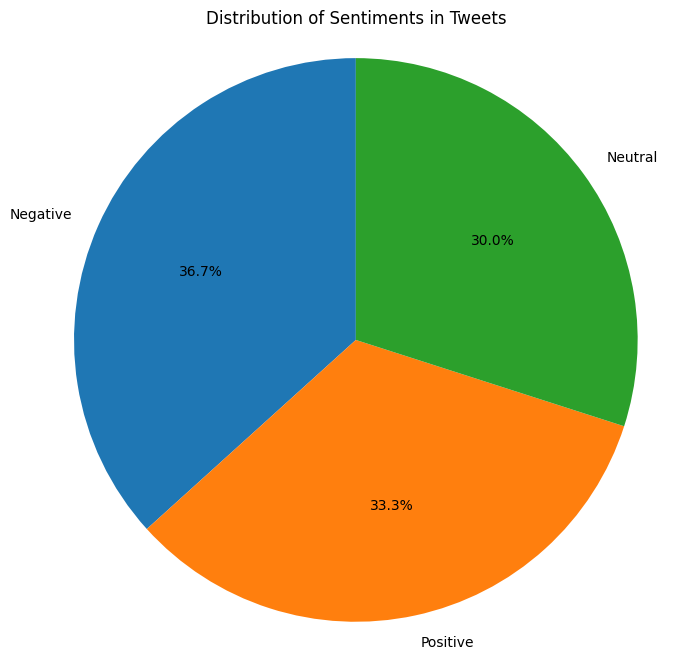

In [ ]:
sentiment_counts = train_dir['sentiment'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiments in Tweets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Test Dataset

In [ ]:
test_dir.head()

,Tweet ID,entity,sentiment,Tweet content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
test_dir.tail()

,Tweet ID,entity,sentiment,Tweet content
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.
998,6960,johnson&johnson,Neutral,Johnson & Johnson to stop selling talc baby po...


In [ ]:
test_dir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       999 non-null    int64 
 1   entity         999 non-null    object
 2   sentiment      999 non-null    object
 3   Tweet content  999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [ ]:
test_dir.describe()

,Tweet ID
count,999.000000
mean,6435.159159
std,3728.912226
min,6.000000
25%,3241.500000
50%,6560.000000
75%,9662.500000
max,13197.000000


In [ ]:
test_dir.shape

(999, 4)

In [ ]:
test_dir.columns

Index(['Tweet ID', 'entity', 'sentiment', 'Tweet content'], dtype='object')

In [ ]:
test_dir.isnull().sum()

,0
Tweet ID,0
entity,0
sentiment,0
Tweet content,0


In [ ]:
test_dir.duplicated().sum()
test_dir.drop_duplicates(inplace=True)

In [ ]:
test_dir.drop(columns=['Tweet ID'], inplace=True)
test_dir

,entity,sentiment,Tweet content
0,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Google,Neutral,Now the President is slapping Americans in the...
4,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...
994,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
test_dir['entity'].value_counts()

,count
entity,
RedDeadRedemption(RDR),40
johnson&johnson,39
PlayerUnknownsBattlegrounds(PUBG),38
FIFA,38
LeagueOfLegends,37
ApexLegends,36
Nvidia,35
TomClancysRainbowSix,35
GrandTheftAuto(GTA),35


In [ ]:
test_dir['sentiment'].value_counts()

,count
sentiment,
Neutral,285
Positive,277
Negative,266
Irrelevant,171


In [ ]:
test_dir = test_dir[test_dir['sentiment'] != 'Irrelevant']

In [ ]:
test_dir['sentiment'].value_counts()

,count
sentiment,
Neutral,285
Positive,277
Negative,266


In [ ]:
test_dir['Tweet content'].isnull().sum()

np.int64(0)

In [ ]:
test_dir.dropna(subset=['Tweet content'], inplace=True)

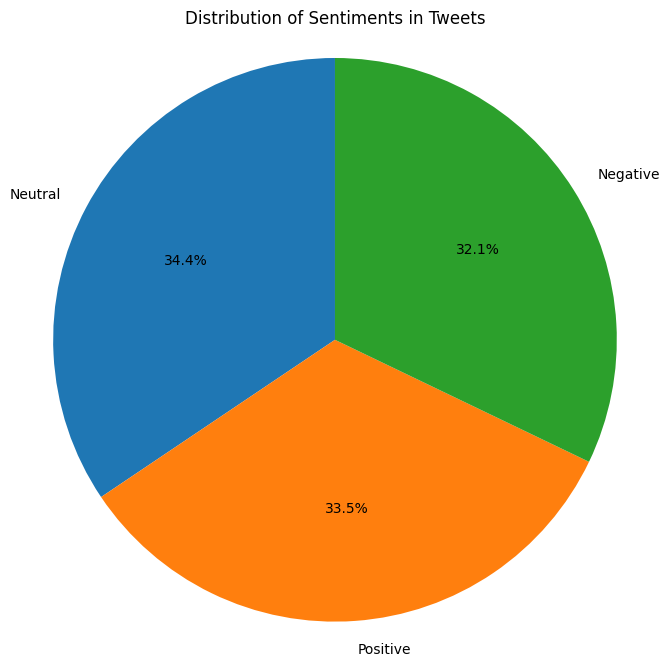

In [ ]:
sentiment_counts = test_dir['sentiment'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiments in Tweets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Split 80% train, 20% validation

In [ ]:
# Split 80% train, 20% validation, stratified by sentiment to keep class balance
train_data, val_data = train_test_split(
    train_dir,
    test_size=0.2,
    random_state=42,
    stratify=train_dir['sentiment']
)

# Text Preprocessing for Sentiment Analysis

## Hyperparameters for Text Tokenization and Padding

In [ ]:
# Maximum number of words to keep based on word frequency
max_words = 5000

# Maximum length of each input sequence (in words); shorter sequences will be padded
max_len = 100

## Tokenization and Padding of Tweet Texts

In [ ]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_words)

# Fit tokenizer on train texts only
tokenizer.fit_on_texts(train_data['Tweet content'])

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['Tweet content'])
val_sequences = tokenizer.texts_to_sequences(val_data['Tweet content'])
test_sequences = tokenizer.texts_to_sequences(test_dir['Tweet content'])

# Pad sequences to fixed length
train_padded = pad_sequences(train_sequences, maxlen=max_len)
val_padded = pad_sequences(val_sequences, maxlen=max_len)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

## Data Preparation

In [ ]:
# Assign padded tweet sequences to training features
X_train = train_padded

# Assign corresponding sentiment labels as training targets
y_train = train_data['sentiment']

# Assign padded tweet sequences to validation features
X_val = val_padded

# Assign corresponding sentiment labels as validation targets
y_val = val_data['sentiment']

# Assign padded tweet sequences to testing features (from test_dir)
X_test = test_padded

# Assign corresponding sentiment labels as testing targets
y_test = test_dir['sentiment']

## Encoding Sentiment Labels

In [ ]:
# Create a LabelEncoder instance
le = LabelEncoder()

# Fit label encoder on train labels only
y_train = le.fit_transform(train_data['sentiment'])
y_val = le.transform(val_data['sentiment'])
y_test = le.transform(test_dir['sentiment'])

# Convert labels to categorical (one-hot)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Model Phase

## 1. RNN Model

In [ ]:
# Clear Backend Session
tf.keras.backend.clear_session()

# Model Build
model = Sequential([
    # Embedding layer to convert word indices into dense vectors of fixed size
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),

    # Bidirectional SimpleRNN to capture context from both past and future
    # L2 regularization is used to prevent overfitting
    Bidirectional(SimpleRNN(64, return_sequences=False, kernel_regularizer=l2(0.001))),

    # Dropout layer to randomly drop 60% of neurons during training for regularization
    Dropout(0.6),

    # Dense layer with ReLU activation and L2 regularization for learning non-linear features
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),

    # Additional Dropout layer to further reduce overfitting
    Dropout(0.5),

    # Output layer with softmax activation for multiclass classification (3 classes)
    Dense(3, activation='softmax')
])

# Define input shape for the model (batch_size=None, sequence_length=max_len)
model.build(input_shape=(None, max_len))

# Model Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,963 (1.32 MB)

 Trainable params: 344,963 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping

In [ ]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

## Train the model

In [ ]:
history = model.fit(
    X_train,        # training features (padded sequences)
    y_train,        # training labels (one-hot encoded)
    validation_data=(X_val, y_val),  # validation features and labels
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/30
739/739 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.4353 - loss: 1.2042 - val_accuracy: 0.6992 - val_loss: 0.7845
Epoch 2/30
739/739 ━━━━━━━━━━━━━━━━━━━━ 54s 74ms/step - accuracy: 0.7457 - loss: 0.7082 - val_accuracy: 0.7914 - val_loss: 0.5728
Epoch 3/30
739/739 ━━━━━━━━━━━━━━━━━━━━ 81s 72ms/step - accuracy: 0.8383 - loss: 0.4745 - val_accuracy: 0.8189 - val_loss: 0.4975
Epoch 4/30
739/739 ━━━━━━━━━━━━━━━━━━━━ 83s 73ms/step - accuracy: 0.8843 - loss: 0.3567 - val_accuracy: 0.8111 - val_loss: 0.5269
Epoch 5/30
739/739 ━━━━━━━━━━━━━━━━━━━━ 53s 72ms/step - accuracy: 0.9070 - loss: 0.2892 - val_accuracy: 0.8273 - val_loss: 0.5118
Epoch 6/30
739/739 ━━━━━━━━━━━━━━━━━━━━ 52s 71ms/step - accuracy: 0.9210 - loss: 0.2495 - val_accuracy: 0.8236 - val_loss: 0.5321
Epoch 7/30
739/739 ━━━━━━━━━━━━━━━━━━━━ 85s 75ms/step - accuracy: 0.9339 - loss: 0.2142 - val_accuracy: 0.8349 - val_loss: 0.5135
Epoch 8/30
739/739 ━━━━━━━━━━━━━━━━━━━━ 80s 72ms/step - accuracy: 0.9375 - loss: 0.2041 - 

# Model Training Metrics

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss*100:.4f}")
print(f"Test Accuracy: {accuracy * 100:.4f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9005 - loss: 0.3443
Test Loss: 35.9349
Test Accuracy: 89.2512%


## Model (Accuracy and Loss)

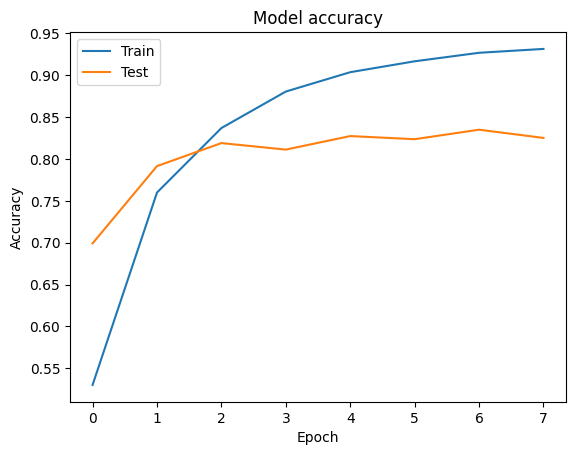

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

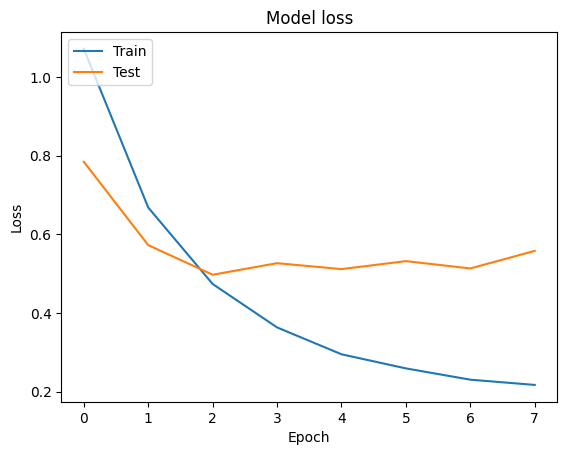

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predictions on test set

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


## Classification Report


In [ ]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       266
           1       0.91      0.85      0.88       285
           2       0.85      0.93      0.89       277

    accuracy                           0.89       828
   macro avg       0.89      0.89      0.89       828
weighted avg       0.89      0.89      0.89       828



## Confusion Matrix

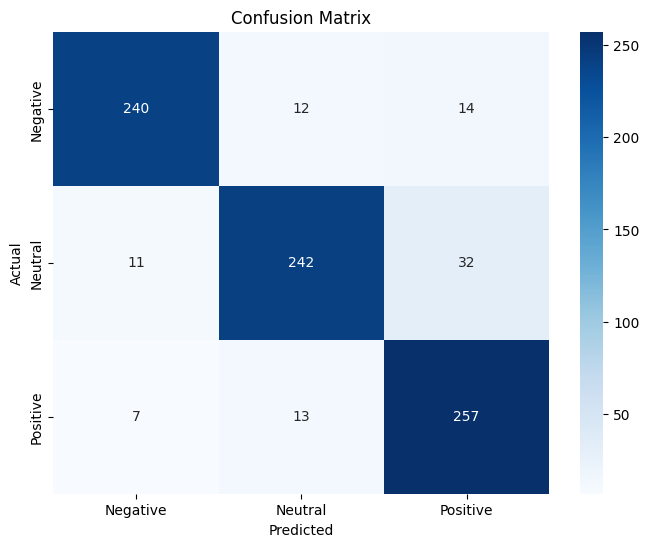

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Receiver Operating Characteristic (ROC) Curves

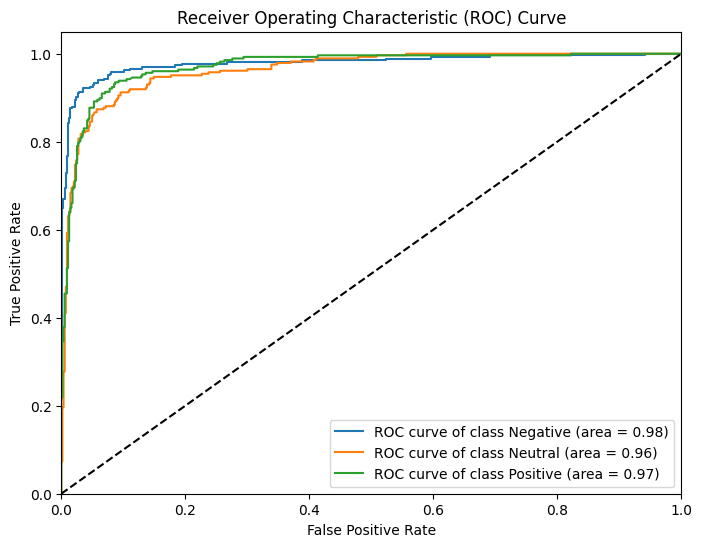

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to a one-hot encoded format suitable for roc_curve
y_test_roc = np.argmax(y_test, axis=1)
# Get the number of classes from the shape of y_test
num_classes = y_test.shape[1] # assign num_classes
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc == i, y_pred[:, i]) # Modify roc_curve call
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Precision-Recall Curve

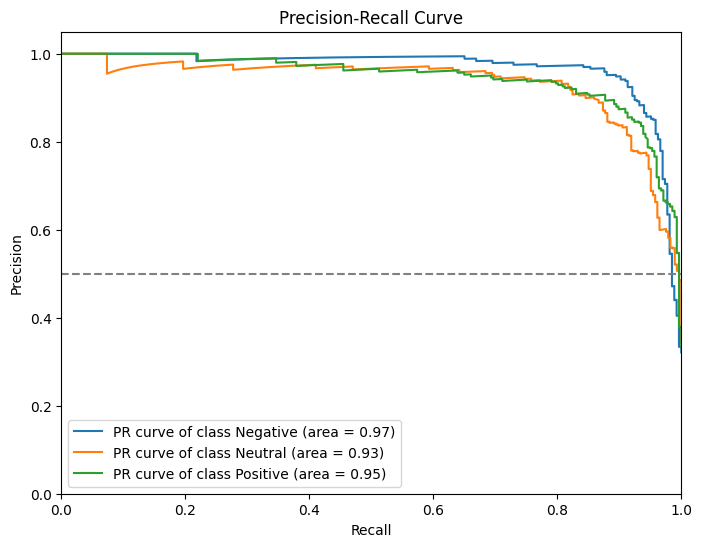

In [ ]:
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_roc == i, y_pred[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

#Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'PR curve of class {le.classes_[i]} (area = {pr_auc[i]:0.2f})')

plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Model Test

In [ ]:
new_tweets = ["This is great!", "This is bad!", "go to bed early!"]

# Preprocess the new tweets
new_sequences = tokenizer.texts_to_sequences(new_tweets)
new_padded = pad_sequences(new_sequences, maxlen=max_len)

# Make predictions
new_predictions = model.predict(new_padded)

# Convert probabilities to class labels
new_predicted_classes = np.argmax(new_predictions, axis=1)

# Get the sentiment labels
predicted_sentiments = le.inverse_transform(new_predicted_classes)

# Print the predicted sentiments
for tweet, sentiment in zip(new_tweets, predicted_sentiments):
    print(f"Tweet: {tweet}")
    print(f"Predicted Sentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tweet: This is great!
Predicted Sentiment: Positive

Tweet: This is bad!
Predicted Sentiment: Negative

Tweet: go to bed early!
Predicted Sentiment: Positive



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

new_tweets = [
    "Just landed my dream job! Feeling on top of the world!",
    "Ugh, this app crashes every time. Absolute trash.",
    "Remember to stay hydrated and take breaks today!"
]

# Preprocess the new tweets
new_sequences = tokenizer.texts_to_sequences(new_tweets)
new_padded = pad_sequences(new_sequences, maxlen=max_len)

# Make predictions
new_predictions = model.predict(new_padded)

# Convert probabilities to class labels
new_predicted_classes = np.argmax(new_predictions, axis=1)

# Get the sentiment labels
predicted_sentiments = le.inverse_transform(new_predicted_classes)

# Print the predicted sentiments
for tweet, sentiment in zip(new_tweets, predicted_sentiments):
    print(f"Tweet: {tweet}")
    print(f"Predicted Sentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tweet: Just landed my dream job! Feeling on top of the world!
Predicted Sentiment: Positive

Tweet: Ugh, this app crashes every time. Absolute trash.
Predicted Sentiment: Negative

Tweet: Remember to stay hydrated and take breaks today!
Predicted Sentiment: Positive



# Save Model

In [ ]:
RNN=model.save(f'sentiment_analysis_model{accuracy * 100:.2f}acc.h5')

## 2. GRU MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

# Clear previous sessions
tf.keras.backend.clear_session()

# Define your constants
max_words = 10000     # Or vocab size from tokenizer
max_len = 100         # Or your max sequence length

# Build the model
model = Sequential([
    # Embedding Layer
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),

    # First Bidirectional GRU layer (returning sequences for stacking)
    Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(0.001))),
    Dropout(0.3),

    # Second Bidirectional GRU layer
    Bidirectional(GRU(32, return_sequences=False, kernel_regularizer=l2(0.001))),
    Dropout(0.3),

    # Fully Connected Layers
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    # Output Layer
    Dense(3, activation='softmax')  # Adjust if not 3-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Build model input shape
model.build(input_shape=(None, max_len))

# Model summary
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,111,619 (4.24 MB)

 Trainable params: 1,111,619 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train,        # training features (padded sequences)
    y_train,        # training labels (one-hot encoded)
    validation_data=(X_val, y_val),  # validation features and labels
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 274s 358ms/step - accuracy: 0.4842 - loss: 1.1661 - val_accuracy: 0.7062 - val_loss: 0.7357
Epoch 2/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 273s 369ms/step - accuracy: 0.7626 - loss: 0.6426 - val_accuracy: 0.7818 - val_loss: 0.5889
Epoch 3/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 271s 366ms/step - accuracy: 0.8279 - loss: 0.4961 - val_accuracy: 0.8030 - val_loss: 0.5440
Epoch 4/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 268s 363ms/step - accuracy: 0.8549 - loss: 0.4278 - val_accuracy: 0.8154 - val_loss: 0.5092
Epoch 5/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 316s 355ms/step - accuracy: 0.8700 - loss: 0.3851 - val_accuracy: 0.8209 - val_loss: 0.5144
Epoch 6/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 270s 365ms/step - accuracy: 0.8849 - loss: 0.3484 - val_accuracy: 0.8238 - val_loss: 0.5135
Epoch 7/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 322s 365ms/step - accuracy: 0.8961 - loss: 0.3204 - val_accuracy: 0.8276 - val_loss: 0.5019
Epoch 8/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 324s 368ms/step - accuracy: 0.9024 -

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss*100:.4f}")
print(f"Test Accuracy: {accuracy * 100:.4f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9029 - loss: 0.3169
Test Loss: 32.4584
Test Accuracy: 90.2174%


In [ ]:
# Optional: Save best model during training
checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'
)

In [ ]:
# Save model in .h5 format
model.save("sentiment_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("sentiment_model.h5")

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# New tweets to test
new_tweets = [
    "I'm feeling amazing today! Everything is going right.",
    "This is literally the worst update ever.",
    "Make sure to backup your files before restarting."
]

# Preprocess
new_sequences = tokenizer.texts_to_sequences(new_tweets)
new_padded = pad_sequences(new_sequences, maxlen=max_len)

# Predict
new_predictions = model.predict(new_padded)

# Get predicted class indices
new_predicted_classes = np.argmax(new_predictions, axis=1)

# Convert class indices to actual sentiment labels
predicted_sentiments = le.inverse_transform(new_predicted_classes)

# Display results
for tweet, sentiment in zip(new_tweets, predicted_sentiments):
    print(f"Tweet: {tweet}")
    print(f"Predicted Sentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
Tweet: I'm feeling amazing today! Everything is going right.
Predicted Sentiment: Positive

Tweet: This is literally the worst update ever.
Predicted Sentiment: Negative

Tweet: Make sure to backup your files before restarting.
Predicted Sentiment: Neutral



## 3. LSTM Model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# ===== Encode labels =====
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_data['sentiment'])
y_val_encoded = label_encoder.transform(val_data['sentiment'])
y_test_encoded = label_encoder.transform(test_dir['sentiment'])

# Convert to one-hot vectors for categorical_crossentropy loss
y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

num_classes = len(train_data['sentiment'].unique())
print("Number of classes:", num_classes)

model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()


# ===== Train the model =====
history = model_lstm.fit(
    train_padded,
    y_train_cat,
    epochs=5,
    batch_size=128,
    validation_data=(val_padded, y_val_cat),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
    verbose=1
)

Number of classes: 3


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 90s 235ms/step - accuracy: 0.5409 - loss: 0.9278 - val_accuracy: 0.7524 - val_loss: 0.6075
Epoch 2/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 145s 244ms/step - accuracy: 0.7960 - loss: 0.5183 - val_accuracy: 0.7969 - val_loss: 0.5103
Epoch 3/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 140s 240ms/step - accuracy: 0.8445 - loss: 0.4017 - val_accuracy: 0.8204 - val_loss: 0.4591
Epoch 4/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 144s 245ms/step - accuracy: 0.8764 - loss: 0.3173 - val_accuracy: 0.8305 - val_loss: 0.4435
Epoch 5/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 105s 283ms/step - accuracy: 0.8948 - loss: 0.2701 - val_accuracy: 0.8396 - val_loss: 0.4421


In [ ]:
# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1  # optional: prints built-in message when stopping
)

# Define model architecture
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model with early stopping callback
history = model_lstm.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop]
)

# Print message if early stopping triggered
if early_stop.stopped_epoch > 0:
    print(f"Training stopped early at epoch {early_stop.stopped_epoch + 1} "
          f"due to no improvement in validation loss for {early_stop.patience} epochs.")
else:
    print("Training completed for all epochs without early stopping.")


Epoch 1/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 165s 430ms/step - accuracy: 0.5519 - loss: 0.9158 - val_accuracy: 0.7596 - val_loss: 0.6126
Epoch 2/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 167s 451ms/step - accuracy: 0.7953 - loss: 0.5234 - val_accuracy: 0.8026 - val_loss: 0.5144
Epoch 3/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 207s 465ms/step - accuracy: 0.8485 - loss: 0.3916 - val_accuracy: 0.8218 - val_loss: 0.4576
Epoch 4/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 196s 450ms/step - accuracy: 0.8818 - loss: 0.3090 - val_accuracy: 0.8354 - val_loss: 0.4438
Epoch 5/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 201s 447ms/step - accuracy: 0.8992 - loss: 0.2598 - val_accuracy: 0.8414 - val_loss: 0.4362
Epoch 6/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 203s 451ms/step - accuracy: 0.9095 - loss: 0.2329 - val_accuracy: 0.8461 - val_loss: 0.4363
Epoch 7/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 201s 449ms/step - accuracy: 0.9219 - loss: 0.2021 - val_accuracy: 0.8510 - val_loss: 0.4328
Epoch 8/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 203s 451ms/step - accuracy: 0.9293 -

In [ ]:
test_loss, test_acc = model_lstm.evaluate(X_test, y_test_cat, batch_size=128)
print(f"Test Loss: {test_loss *100:.4f}")
print(f"Test Accuracy: {test_acc*100:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9180 - loss: 0.3097
Test Loss: 29.7662
Test Accuracy: 91.3043


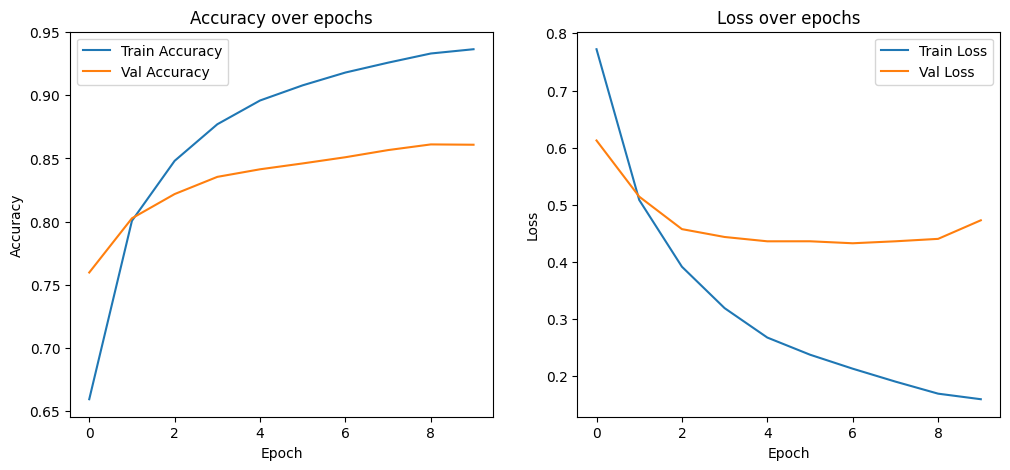

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       266
           1       0.92      0.88      0.90       285
           2       0.91      0.92      0.92       277

    accuracy                           0.91       828
   macro avg       0.91      0.91      0.91       828
weighted avg       0.91      0.91      0.91       828



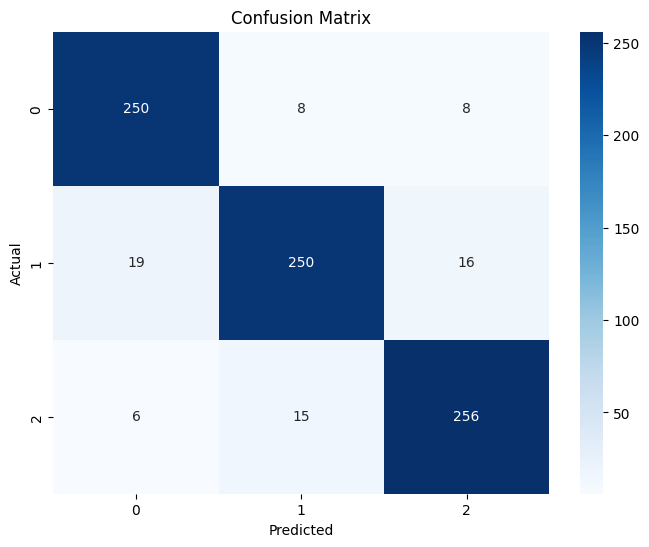

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict class probabilities on test set
y_pred_probs = model_lstm.predict(X_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
LSTM=model_lstm.save('lstm_sentiment_model.h5')

In [ ]:
def predict_sentiment(tweet, tokenizer, model, max_len, label_encoder):
    # Make sure tweet is string and clean if needed
    tweet = str(tweet)

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([tweet])
    padded = pad_sequences(seq, maxlen=max_len)

    # Predict
    pred = model.predict(padded)

    # Get the index of the highest probability
    pred_class_idx = pred.argmax(axis=1)[0]

    # Convert back to label
    pred_label = label_encoder.inverse_transform([pred_class_idx])[0]

    return pred_label


In [ ]:
sample_tweets = [
    "Just nailed my presentation! Feeling on top of the world. 🌟",  # Positive
    "The meeting went okay, nothing exciting to report.",            # Neutral
    "Honestly, the service here is awful and I’m so frustrated.",    # Negative
    "Did you see the new update? Check out the website for details." # Netural
]

for tweet in sample_tweets:
    pred = predict_sentiment(tweet, tokenizer, model_lstm, max_len, label_encoder)
    print(f"Tweet: {tweet}\nPredicted Sentiment: {pred}\n{'-'*50}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Tweet: Just nailed my presentation! Feeling on top of the world. 🌟
Predicted Sentiment: Positive
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tweet: The meeting went okay, nothing exciting to report.
Predicted Sentiment: Neutral
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Tweet: Honestly, the service here is awful and I’m so frustrated.
Predicted Sentiment: Negative
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Tweet: Did you see the new update? Check out the website for details.
Predicted Sentiment: Neutral
--------------------------------------------------


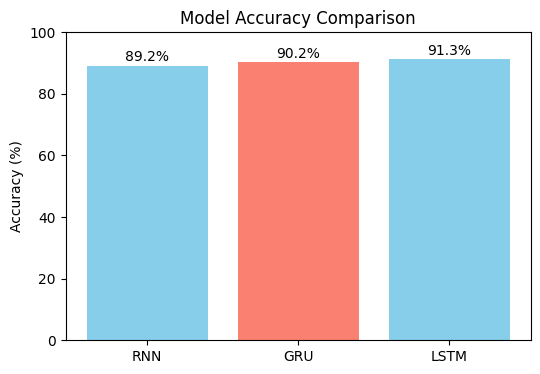

In [81]:
import matplotlib.pyplot as plt

# Your model names and accuracies (in %)
models = ['RNN', 'GRU','LSTM']
accuracies = [89.2, 90.2, 91.3]

plt.figure(figsize=(6,4))
bars = plt.bar(models, accuracies, color=['skyblue', 'salmon'])

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval}%", ha='center', va='bottom')

plt.ylim(0, 100)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.show()
